# Comparative Analysis of Image Classification Methods

In this project, I aim to conduct a comparison of various image classification methodologies, including Random Forest, SVM Radial Basis Function (RBF), XGBoost, Neural Network, and Convolutional Neural Networks (CNN). My objective is to evaluate and compare these techniques based on their accuracy, and efficiency in classifying images. This analysis will provide insights into the strengths and weaknesses of each method, guiding future applications in image classification tasks.

## Result

The analysis concludes that the Convolutional Neural Network (CNN) is well suit for image classification tasks, achieving an impressive 99% accuracy. Closely following is the SVM Radial Basis Function (RBF), which attained 98.7% accuracy. Other examined models also performed admirably, accuracy rate for these are all above 95%.

## Setup

In [1]:
display_plotly_as_html_ = False
display_plotly_as_png_ = !display_plotly_as_html_

In [2]:
from IPython.core.magic import register_cell_magic

@register_cell_magic
def display_plotly_as_png(line, cell):
    if display_plotly_as_png_:
        get_ipython().run_cell(cell)

@register_cell_magic
def display_plotly_as_html(line, cell):
    if display_plotly_as_html_:
        get_ipython().run_cell(cell)

get_ipython().register_magic_function(display_plotly_as_png, "cell")
get_ipython().register_magic_function(display_plotly_as_html, "cell")

In [3]:
%%capture
%%display_plotly_as_png
!pip install -U kaleido fastapi python-multipart uvicorn

In [4]:
%%capture
!pip install umap-learn

In [5]:
import time
import random
from IPython.display import Image as ImageDisplay

from keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import umap

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


In [6]:
#Load data set

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# (train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

img_h = train_images.shape[1]
img_w = train_images.shape[2]

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [7]:
train_images_flattened = train_images.reshape((60000, img_h * img_w))
test_images_flattened = test_images.reshape((10000, img_h * img_w))

train_images_normalized = train_images_flattened / 255.0
test_images_normalized = test_images_flattened / 255.0

## Image Visualization

Visualizing image data is a critical step in understanding the underlying patterns and characteristics that drive successful classification.

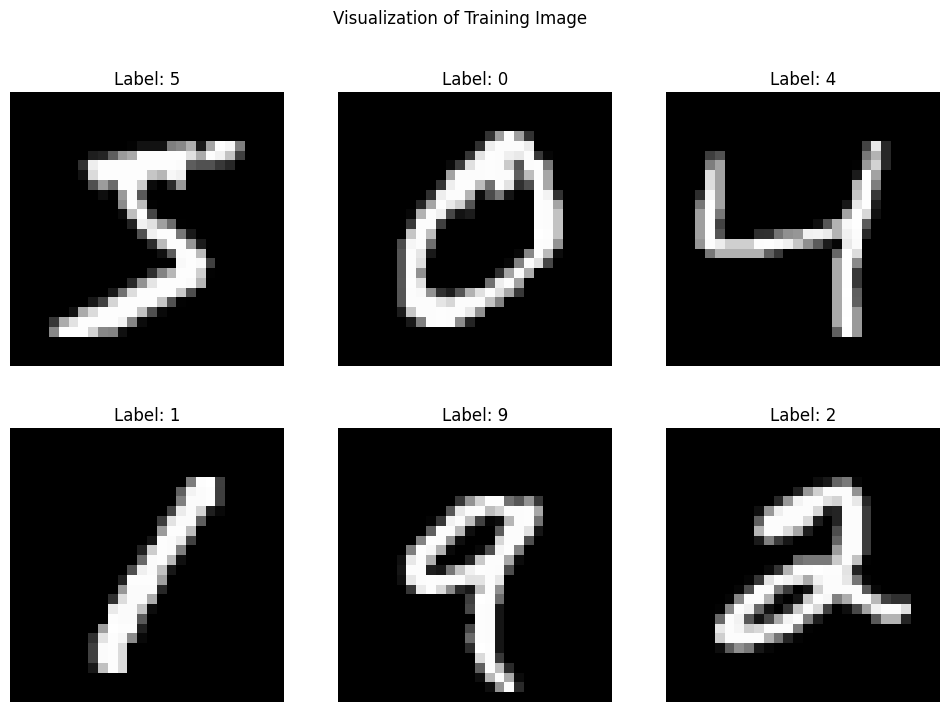

In [8]:
sample_images = train_images_normalized[:6]
sample_labels = train_labels[:6]

plt.figure(figsize=(12, 8))
for i in range(6):
    ax = plt.subplot(2, 3, i + 1)
    ax.imshow(sample_images[i].reshape(img_h, img_w), cmap="gray")
    ax.set_title(f"Label: {sample_labels[i]}")
    ax.axis("off")
plt.suptitle("Visualization of Training Image")
plt.show()

## Principal Component Analysis (PCA)
Principal Component Analysis (PCA) is a powerful statistical technique used in our project to reduce the dimensionality of the image data while retaining most of the important information. This section details the application of PCA and the insights derived from it:

In [9]:
pca = PCA(n_components=0.95)
pca.fit(train_images_normalized)

variance_explained = np.sum(pca.explained_variance_ratio_)
print(f"Number of components, {pca.n_components_}. variance_explained: {variance_explained}")

Number of components, 154. variance_explained: 0.9501960192613034


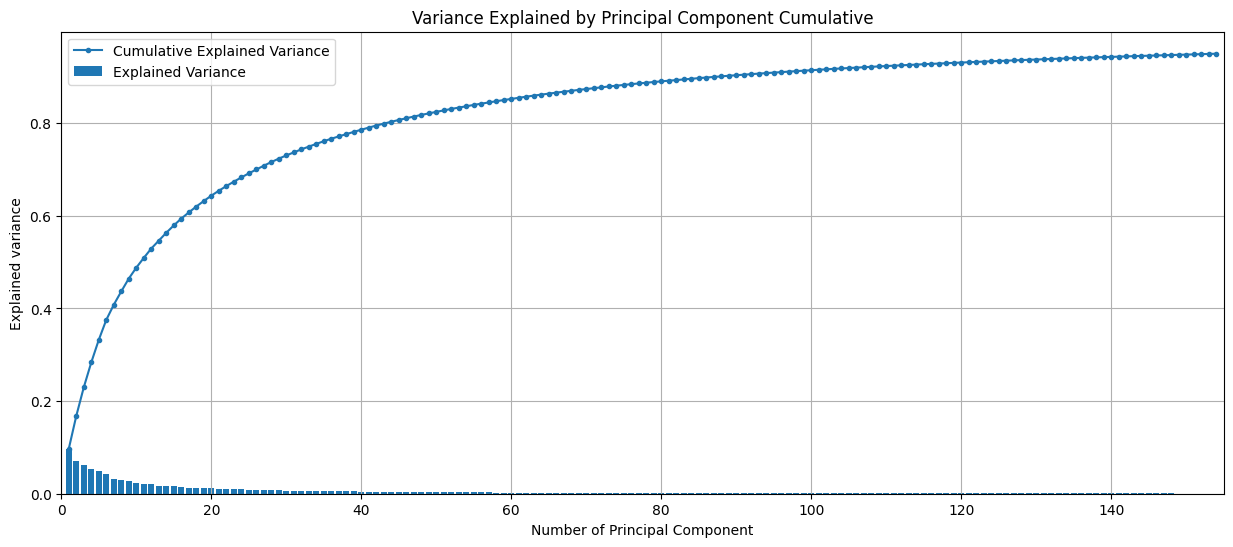

In [10]:
y = np.zeros(pca.n_components_)
for i in range(len(y)):
  if i == 0:
    y[i] = pca.explained_variance_ratio_[i]
  else:
    y[i] = y[i-1] + pca.explained_variance_ratio_[i]

plt.figure(figsize=(15, 6))
plt.plot([i+1 for i in range(len(y))], y, marker="o", markersize=3, label="Cumulative Explained Variance")
plt.bar(x=[i+1 for i in range(len(y))], height=pca.explained_variance_ratio_, label="Explained Variance")
plt.grid(True)
plt.legend()
plt.ylabel("Explained variance")
plt.xlabel("Number of Principal Component")
plt.title("Variance Explained by Principal Component Cumulative")
plt.xlim(0, len(y)+1)
plt.show()

In [11]:
# pca = PCA(n_components=40)
pca = PCA(n_components=0.8)
pca.fit(train_images_normalized)

variance_explained = np.sum(pca.explained_variance_ratio_)
print(f"Number of components: {pca.n_components_}. variance_explained: {variance_explained}")

pca_transformed_data = pca.transform(train_images_normalized)
pca_transformed_data_test_images = pca.transform(test_images_normalized)

Number of components: 44. variance_explained: 0.8032907553836799


## PCA visualization

Visual representation of Principal Component Analysis (PCA) outcomes played a pivotal role in my understanding of the dataset"s inherent structure. This section elaborates on the visualization techniques employed and the resulting insights:

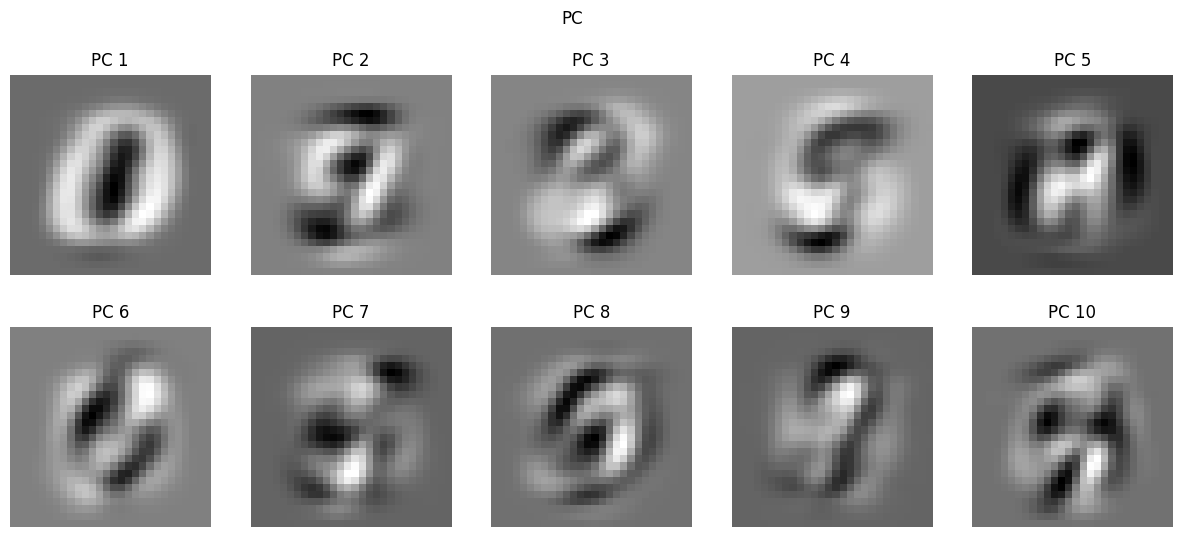

In [12]:
n = 10
plt.figure(figsize=(15, 6))
for i in range(n):
    ax = plt.subplot(2, int((n+1)/2), i + 1)
    ax.imshow(pca.components_[i].reshape(img_h, img_w), cmap="gray")
    ax.set_title(f"PC {i+1}")
    ax.axis("off")
plt.suptitle("PC")
plt.show()

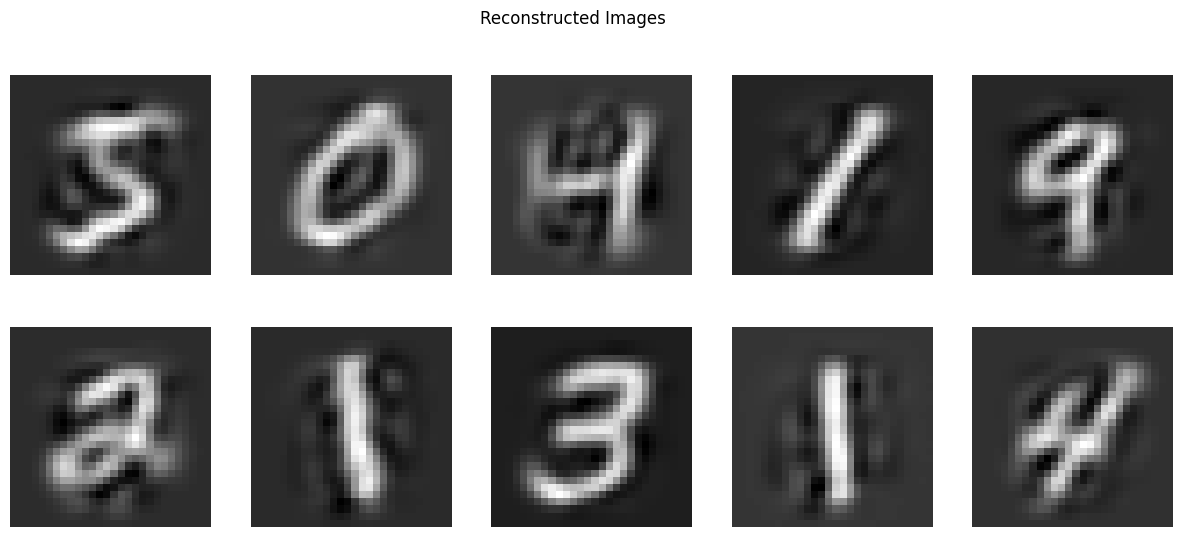

In [13]:
num = 10
reconstructed_images = pca.inverse_transform(pca_transformed_data[:num])

plt.figure(figsize=(15, 6))
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    ax.imshow(reconstructed_images[i].reshape(img_h, img_w), cmap="gray")
    ax.axis("off")
plt.suptitle("Reconstructed Images")
plt.show()

The first picture is the sum of the following PC (only first 10 PC are shown).

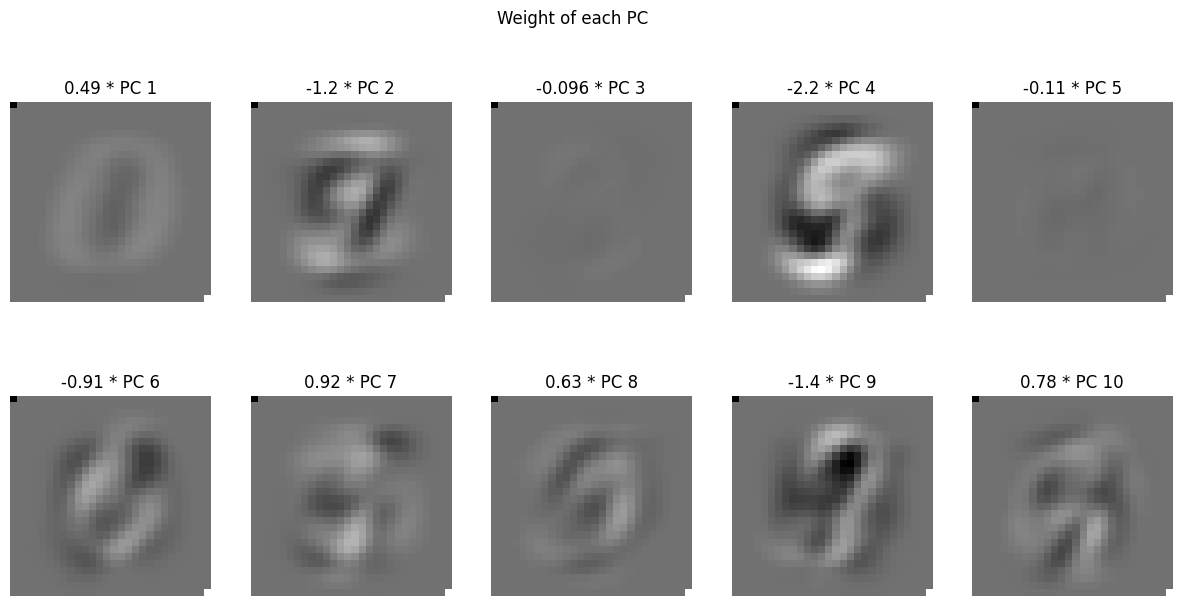

In [14]:
pca_0 = np.copy(pca_transformed_data[0])
imgs = np.zeros((10, img_h * img_w))
for i in range(10):
    img = pca_0[i] * pca.components_[i]
    imgs[i, :] = img

plt.figure(figsize=(15, 7))
plt.suptitle(f"Weight of each PC")
for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    img = imgs[i, :]
    img[0] = imgs.min()
    img[-1] = imgs.max()
    ax.imshow(img.reshape(img_h, img_w), cmap="gray")
    ax.set_title(f"{pca_0[i]:.2} * PC {i+1}")
    ax.axis("off")

plt.show()

## t-SNE Visualization Analysis
In this segment, t-SNE (t-distributed Stochastic Neighbor Embedding) has been utilized to visualize the transformed data. While there is some overlap among certain classes, most of them are distinctly separable. This observation implies that the classes could be linearly separable following appropriate transformations, indicating a potential for high classification accuracy. The t-SNE results offer valuable insights into the inherent structure of the dataset, suggesting that a well-tuned classifier could achieve notable performance.

In [15]:
num_of_examples_for_t_sne = 1000

# Apply t-SNE to the PCA-transformed data
tsne = TSNE(n_components=2, random_state=0)
tsne_results = tsne.fit_transform(pca_transformed_data[:num_of_examples_for_t_sne])
df_array = np.zeros((num_of_examples_for_t_sne, 3))
df_array[:, :2] = tsne_results
df_array[:, 2] = train_labels[:num_of_examples_for_t_sne]

df = pd.DataFrame(df_array, columns=["feature 1", "feature 2", "labels"])
df = df.sort_values(by=["labels"])
# Visualize the results
df["labels"] = df["labels"].astype("int").astype("category")
fig = px.scatter(df, x="feature 1", y="feature 2", color="labels", title="t-SNE visualization of PCA-transformed data", width=800, height=800)

In [16]:
%%display_plotly_as_html
fig.show()

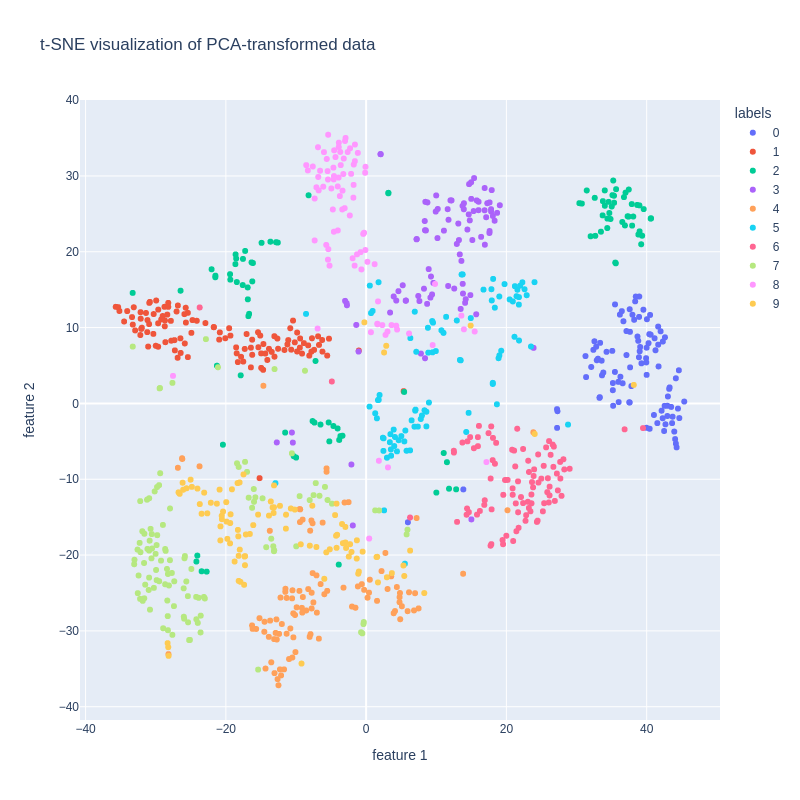

In [17]:
%%display_plotly_as_png
ImageDisplay(fig.to_image(format="png"))

In [18]:
# Visualizate in 3d

tsne = TSNE(n_components=3, random_state=0)
tsne_results = tsne.fit_transform(pca_transformed_data[:num_of_examples_for_t_sne])
df_array = np.zeros((num_of_examples_for_t_sne, 4))
df_array[:, :3] = tsne_results
df_array[:, 3] = train_labels[:num_of_examples_for_t_sne]

df = pd.DataFrame(df_array, columns=["feature 1", "feature 2", "feature 3", "labels"])
df = df.sort_values(by=["labels"])
df["labels"] = df["labels"].astype("int").astype("category")
fig = px.scatter_3d(df, x="feature 1", y="feature 2", z="feature 3", color="labels", title="t-SNE visualization of PCA-transformed data")


In [19]:
%%display_plotly_as_html
fig.show()

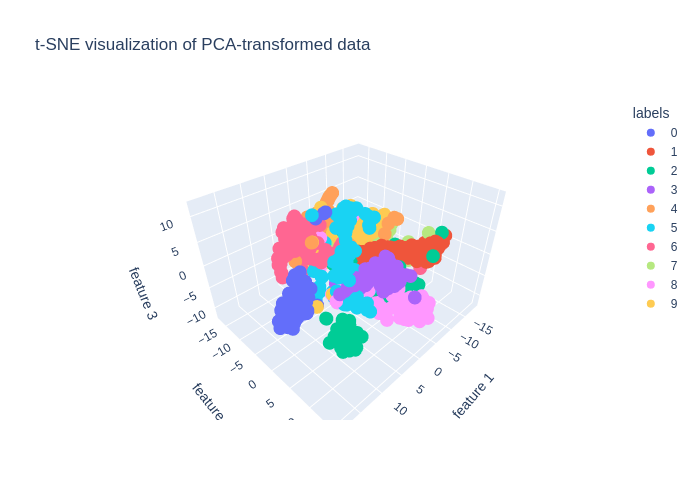

In [20]:
%%display_plotly_as_png
ImageDisplay(fig.to_image(format="png"))

In [21]:
# Apply densMAP to the PCA-transformed data
reducer = umap.UMAP(densmap=True)
embedding = reducer.fit_transform(pca_transformed_data[:num_of_examples_for_t_sne])

df_array = np.zeros((num_of_examples_for_t_sne, 3))
df_array[:, :2] = embedding[:, :2]
df_array[:, 2] = train_labels[:num_of_examples_for_t_sne]

df = pd.DataFrame(df_array, columns=["feature 1", "feature 2", "labels"])
df = df.sort_values(by=["labels"])
df["labels"] = df["labels"].astype("int").astype("category")
fig = px.scatter(df, x="feature 1", y="feature 2", color="labels", title="densMAP visualization of PCA-transformed data", width=800, height=800)

In [22]:
%%display_plotly_as_html
fig.show()

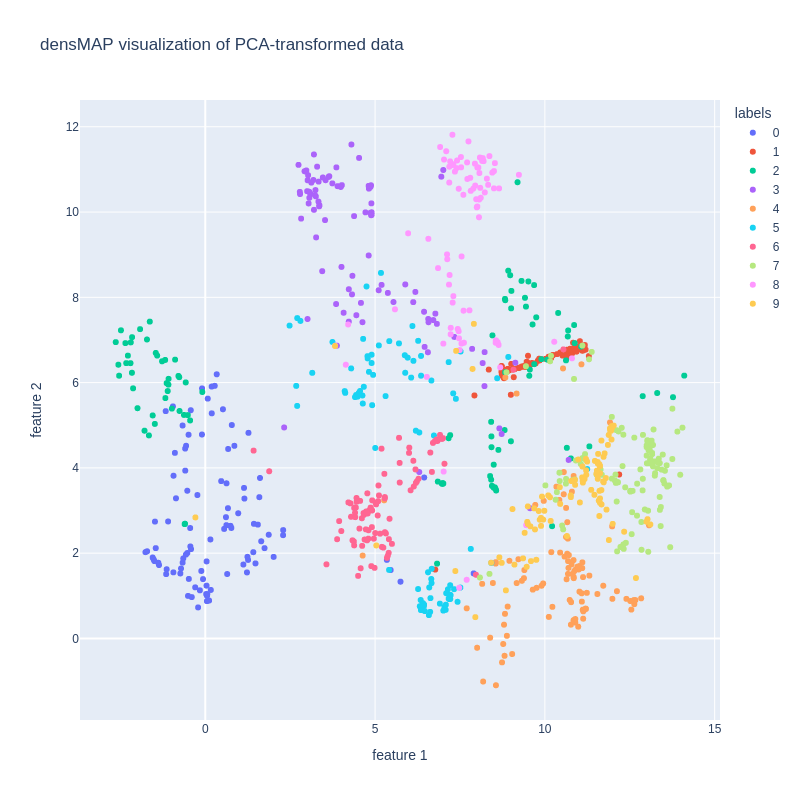

In [23]:
%%display_plotly_as_png
ImageDisplay(fig.to_image(format="png"))

## Training the Classifiers
In this phase, I useing a 4-fold cross-validation and select a subset of the training data to ensure manageable training durations. The classifiers selected for this study are diverse, each offering unique strengths in handling different aspects of image classification. The lineup includes:

- Random Forest: A robust ensemble method known for its effectiveness in handling large datasets and high dimensionality.
- K-Nearest Neighbors (KNN): A simple yet powerful algorithm that classifies data based on the closest training examples in the feature space.
- Support Vector Classifier (SVC) with Radial Basis Function (RBF) Kernel: Well-suited for non-linear data classification.
- SVC with Polynomial Kernel: Offering an alternative approach to non-linear classification with a polynomial decision boundary.
- Neural Network: A more complex model that can capture intricate patterns in data through its layered architecture.
- Convolutional Neural Network (CNN): Highly specialized for image data, leveraging convolutional layers to efficiently process pixel data.

Each classifier will be evaluated for its performance and efficiency, providing a comprehensive comparison across different methodologies in image classification.

In [24]:
import time
import random
from IPython.display import Image as ImageDisplay

from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline


In [25]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

number_of_splits = 4

train_images_small = train_images[:7000]
train_labels_small = train_labels[:7000]
summary = {}

In [26]:
class ImageTransformer(BaseEstimator, TransformerMixin):
    def reshape_X(self, X):
        n = X.shape[0]
        l = X.shape[1] * X.shape[2]
        return X.reshape((n, l)) / 255.0

    def fit(self, X, y=None):
        pca = PCA(n_components=0.8)
        pca.fit(self.reshape_X(X))
        self.pca = pca
        return self

    def transform(self, X, y=None):
        return self.pca.transform(self.reshape_X(X))

In [27]:
def find_best_param(modelClass, param_grid):
    param_grid_ = {}
    for key in param_grid.keys():
        param_grid_["model__" + key] = param_grid[key]
    pipeline = Pipeline(steps=[('transform', ImageTransformer()), ('model', modelClass())])
    grid_search = GridSearchCV(pipeline, param_grid_, cv=StratifiedKFold(n_splits=number_of_splits), refit=False)
    grid_search.fit(train_images_small, train_labels_small)
    return grid_search.best_params_

def hyperparameter_tuning(modelClass, param_grid, modelName = None):
    best_params = find_best_param(modelClass, param_grid)

    t0 = time.time()

    pipeline = Pipeline(steps=[('transform', ImageTransformer()), ('model', modelClass())])
    pipeline.set_params(**best_params)
    pipeline.fit(train_images, train_labels)

    t1 = time.time()

    y_pred_train = pipeline.predict(train_images)
    accuracy_train = accuracy_score(train_labels, y_pred_train)

    y_pred = pipeline.predict(test_images)
    accuracy = accuracy_score(test_labels, y_pred)

    t2 = time.time()

    if not modelName:
        modelName = modelClass.__name__
    summary[modelName] = {"best_params": best_params, "accuracy": accuracy, "accuracy_train": accuracy_train,
                            "time_train": t1-t0, "time_predict": t2-t1, "time_total": t2-t0,
                            "model": pipeline, "predicts": y_pred}
    return best_params, accuracy

In [28]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {
    "n_estimators": [50, 100, 150],
    "max_depth": [None, 100, 150],
}
hyperparameter_tuning(RandomForestClassifier, param_grid)

({'model__max_depth': 100, 'model__n_estimators': 150}, 0.9549)

In [29]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {
    "n_neighbors": [2, 3, 5, 7],
    "weights": ["uniform", "distance"]
}
hyperparameter_tuning(KNeighborsClassifier, param_grid)

({'model__n_neighbors': 5, 'model__weights': 'distance'}, 0.9755)

In [30]:
from sklearn.svm import SVC

param_grid = {
    "C": [2, 3, 4],
    "gamma": ["scale", "auto"],
    "kernel": ["rbf"]
}
hyperparameter_tuning(SVC, param_grid, "SVC RBF")

({'model__C': 4, 'model__gamma': 'auto', 'model__kernel': 'rbf'}, 0.987)

In [31]:
param_grid = {
    "C": [2, 3, 4],
    "degree": [3, 5],
    "kernel": ["poly"]
}
hyperparameter_tuning(SVC, param_grid, "SVC polynomial")

({'model__C': 3, 'model__degree': 3, 'model__kernel': 'poly'}, 0.9833)

In [32]:
from xgboost import XGBClassifier

param_grid = {
    "max_depth": [5, 6],
    "subsample": [1, 0.75]
}
hyperparameter_tuning(XGBClassifier, param_grid)

({'model__max_depth': 6, 'model__subsample': 0.75}, 0.9671)

In [33]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.regularizers import l2

class NeuralNetworkClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, layers=None, output_size=10, lam=0.1, batch_size=64):
        if layers is None:
            layers = (64, 32)
        self.layers = layers
        self.output_size = output_size
        self.lam = lam
        self.batch_size = batch_size

    def fit(self, X, y):
        y = to_categorical(y)

        model = Sequential()

        for nodes in self.layers:
            model.add(Dense(nodes, activation="relu", kernel_regularizer=l2(self.lam)))

        model.add(Dense(units=self.output_size, activation="softmax"))
        model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
        model.fit(X, y, epochs=20, batch_size=self.batch_size, verbose=0)
        self.model = model
        return self

    def predict(self, X):
        pred = self.model.predict(X, verbose=0)
        return np.argmax(pred, axis=1)


param_grid = {
    "layers": [(64, 32), (64, 32, 32)],
    "lam": [0.0005, 0.001, 0.005],
    "batch_size": [64, 128],
    "output_size": [10]
}
hyperparameter_tuning(NeuralNetworkClassifier, param_grid, "NeuralNetwork")

({'model__batch_size': 64,
  'model__lam': 0.001,
  'model__layers': (64, 32, 32),
  'model__output_size': 10},
 0.9757)

In [34]:
from keras.layers import Conv2D, MaxPooling2D, Flatten

# Load and preprocess the data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.reshape((60000, 28, 28, 1)).astype("float32") / 255
X_test = X_test.reshape((10000, 28, 28, 1)).astype("float32") / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

t0 = time.time()
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation="relu"))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(10, activation="softmax"))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)
t1 = time.time()
_, accuracy_train = model.evaluate(X_train, y_train, verbose=0)
_, accuracy = model.evaluate(X_test, y_test, verbose=0)
t2 = time.time()

summary["CNN"] = {"best_params": {}, "accuracy": accuracy, "accuracy_train": accuracy_train, "time_train": t1-t0, "time_predict": t2-t1, "time_total": t2-t0,
                  "model": model, "predicts": np.argmax(model.predict(X_test, verbose=0), axis=1)}
accuracy

0.9901999831199646

### Visualization of Incorrect Predictions

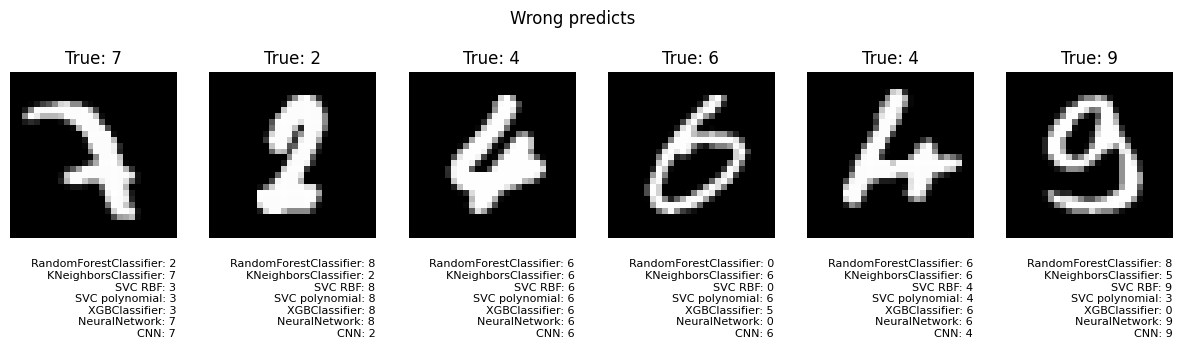

In [35]:
wrong_count = {}
for key in summary.keys():
  wrong_indices = np.where(summary[key]["predicts"] != test_labels)[0]
  for index in wrong_indices:
    wrong_count[index] = wrong_count.get(index, 0) + 1

wrong_count_list = [(key, wrong_count[key]) for key in wrong_count if wrong_count[key] > 3]
random.shuffle(wrong_count_list)

def plot_image(index, ax):
    ax.imshow(test_images[index].reshape(28, 28), cmap="gray")
    t = ""
    for key in summary.keys():
      t += f"{key}: {summary[key]['predicts'][index]}\n"
    ax.set_title(f"True: {test_labels[index]}")
    ax.annotate(t, xy = (1, -0.4), xycoords="axes fraction", ha="right", va="center", fontsize=8)
    ax.axis("off")

fig, axes = plt.subplots(1, 6, figsize=(15, 3))
for i in range(6):
    if i < len(wrong_count_list):
        plot_image(wrong_count_list[i][0], axes[i])
    else:
        axes[i].axis("off")
plt.suptitle("Wrong predicts")
plt.show()


In [36]:
data = [(method, summary[method]["accuracy"], summary[method]["accuracy_train"], summary[method]["time_train"], summary[method]["time_predict"], summary[method]["time_total"]) for method in summary.keys()]
df = pd.DataFrame(data, columns=["method", "accuracy", "accuracy_train", "time_train", "time_predict", "time_total"])
df = df.sort_values(by=["accuracy"], ascending=False)
print(df)

                   method  accuracy  accuracy_train  time_train  time_predict  \
6                     CNN    0.9902        0.997967  503.499187     23.327366   
2                 SVC RBF    0.9870        0.997733   56.862112     86.249022   
3          SVC polynomial    0.9833        0.997817   68.663158     52.632367   
5           NeuralNetwork    0.9757        0.983700   60.856029      7.101779   
1    KNeighborsClassifier    0.9755        1.000000   15.463386     33.665483   
4           XGBClassifier    0.9671        0.999983   69.973087      2.326386   
0  RandomForestClassifier    0.9549        1.000000  136.425343      3.598989   

   time_total  
6  526.826553  
2  143.111135  
3  121.295526  
5   67.957808  
1   49.128869  
4   72.299473  
0  140.024332  


In [37]:
for col in ["time_train", "time_predict", "time_total"]:  # for visualization
  df[col] = np.ceil(df[col]).astype(int)

In [38]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df["method"], y=df["accuracy"], name="accuracy"))

for i, row in df.iterrows():
    fig.add_annotation(
        x=row["method"],
        y=row["accuracy"] + 0.005,
        text=f"{row['accuracy']:.3f}",
        showarrow=False
    )

fig.update_layout(title="Accuracy for each method", xaxis_title="Methods", yaxis_title="accuracy", yaxis=dict(range=[0.9, 1]));

In [39]:
%%display_plotly_as_html
fig.show()

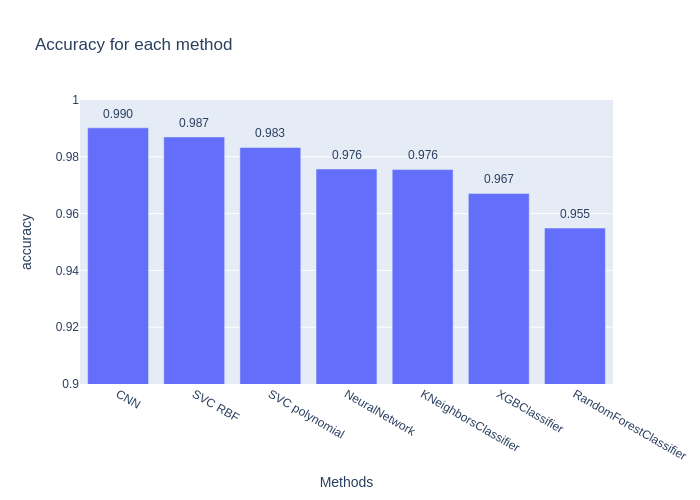

In [40]:
%%display_plotly_as_png
ImageDisplay(fig.to_image(format="png"))

In [41]:
fig = go.Figure()

fig.add_trace(go.Bar(x=df["method"], y=df["time_train"], name=f"Training time for {len(train_labels)} samples"))
fig.add_trace(go.Bar(x=df["method"], y=df["time_predict"], name=f"Prediction time for {len(train_labels) + len(test_labels)} samples"))

for i, row in df.iterrows():
    fig.add_annotation(
        x=row["method"],
        y=row["time_total"] + 8,
        text=str(row["time_total"]),
        showarrow=False
    )

fig.update_layout(barmode="stack", title="Time cost for each method", xaxis_title="Methods", yaxis_title="Time cost (sec)");

In [42]:
%%display_plotly_as_html
fig.show()

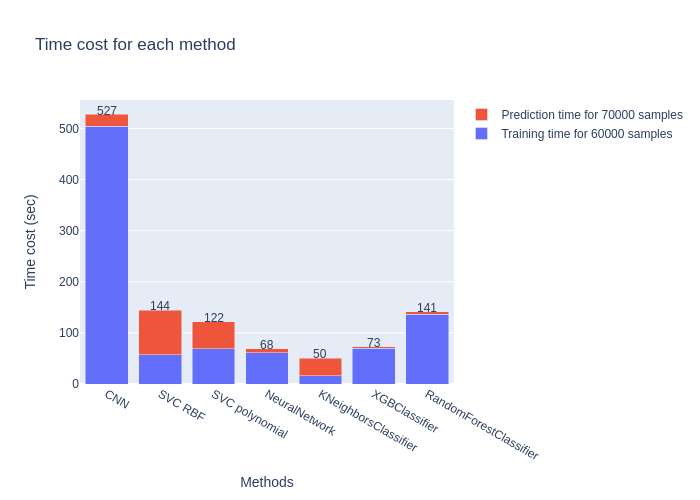

In [43]:
%%display_plotly_as_png
ImageDisplay(fig.to_image(format="png"))

In [45]:
# !rm -rf /README_files
# !rm -rf /README_files.md
# !rm /README_files.zip
# !jupyter nbconvert --to markdown "/classification.ipynb" --output README.md
# !zip -r /README_files.zip /README_files